<H1 style="text-align: center">EEEM079 - Fundamentals of Machine Learning</H1>
<H1 style="text-align: center">Week 3: Regression</H1>

> Dr. Xiatian (Eddy) Zhu, Dr Syed Sameed Husain

> xiatian.zhu@surrey.ac.uk, sameed.husain@surrey.ac.uk


**Introduction**

This lab session is designed to introduce the fundamentals of regression analysis, providing a comprehensive overview of how to solve a regression problem using statistical methods and simulated data sets.

Happy Programming!⚡⚡

# Sources:
* This notebook used (and modified) code from the following repos and sources:
    * https://github.com/jonkrohn/ML-foundations
    * https://github.com/valerija-h/CS551G-Assignment-1.git
    * https://lilianweng.github.io/

# Contents

*   [Data (preparing and loading)](https://colab.research.google.com/drive/1R9sd0vYh2OvIvDZ0BTPt27FLMCOTw2-q#scrollTo=fEDUKrb1yrGo)
*   [Let's build a linear regression model!](https://colab.research.google.com/drive/1R9sd0vYh2OvIvDZ0BTPt27FLMCOTw2-q#scrollTo=kth-JMp5yrGp)
*   [Estimate model parameters with least square minimizer](https://colab.research.google.com/drive/1R9sd0vYh2OvIvDZ0BTPt27FLMCOTw2-q#scrollTo=srdxq9dFyrGr)
*   [[Optional below] Training `LinearRegressionModel()` with gradient descent](https://colab.research.google.com/drive/1R9sd0vYh2OvIvDZ0BTPt27FLMCOTw2-q#scrollTo=TSsm-xcAyrGr)
*   [Making predictions with the two above models (inference)](https://colab.research.google.com/drive/1R9sd0vYh2OvIvDZ0BTPt27FLMCOTw2-q#scrollTo=AsULpqO7yrGv)


In this notebook, you will be introduced to solving linear regression problems using synthetic data in PyTorch. We will first present a model in PyTorch and solve it.


In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.1+cu121'

## 1. Data (preparing and loading)

Let's create synthetic data

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
# this is just the equation of the line. the weight and bias are the 'trainable' parameters in it. So, we will try to find parameter values that when the data X is plugged into the equation we get y's (predictions) that are as close as possilble to the real (ground truth/targets) y's
y = weight * X + bias

# Add noise
noise_mean = 0
noise_stddev = 0.01  # adjust the standard deviation to control the amount of noise
noise = torch.normal(mean=noise_mean, std=noise_stddev, size=y.size())

# Add noise to y
y = y + noise

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3193],
         [0.3289],
         [0.3370],
         [0.3209],
         [0.3628],
         [0.3577],
         [0.3836],
         [0.3820],
         [0.4045],
         [0.4425]]))

#### Note here that X is a vector representing the features of the data, and y is the vector representing the labels (targets)

### Split data into training and test sets

But before we build a model we need to split the data up into a training and test sets. We can create them by splitting our `X` and `y` tensors.

> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples. Contamination of the test set with examples from the training set is a red flag and will hugely drop the confidence of your model's performance.


In [3]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Let's visualise the data we created!

We use model_0 as the least squares and model_1 as the gradient descent.

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     model_0_predict=None,
                     model_1_predict=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if model_0_predict is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, model_0_predict, c="m", s=4, label="model_0")

  if model_1_predict is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, model_1_predict, c="r", s=4, label="model_1")

  # Show the legend
  plt.legend(prop={"size": 14});

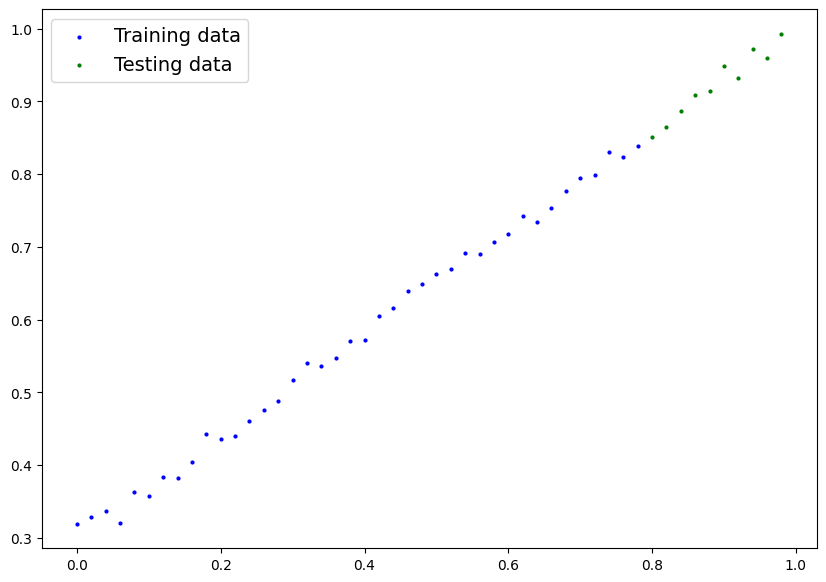

In [5]:
plot_predictions()

## 2. Let's build a linear regression model!

* Use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) to create the model.
* Do you know why we set [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html) to `True`?
* Read the section [`PyTorch: Defining new autograd functions`](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#:~:text=PyTorch%3A%20Defining%20new%20autograd%20functions,-Under%20the%20hood&text=The%20forward%20function%20computes%20output,to%20that%20same%20scalar%20value.) - Are you able to tell what role of the `forward` method is?
* For the interested reader, this is a brief review of Object Oriented Programming (OOD) in Python - https://realpython.com/python3-object-oriented-programming/



In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- nearly everything in PyTorch is a nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch datatype is float32 by default, we explicitly write it here for clarity
                                   requires_grad=True) # <- can we update this value with gradient descent?

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default, we explicitly write it here for clarity
                                requires_grad=True) # <- can we update this value with gradient descent?

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = beta_1*x + beta_0)

### Broadly, there are four essential modules in PyTorch that can be used to create nearly any neural network. There are:
* [`torch.nn`](https://pytorch.org/docs/stable/nn.html)
* [`torch.optim`](https://pytorch.org/docs/stable/optim.html)
* [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
* [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of it like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their uses cases in the [official PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).





In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
# Briefly, manual_seed is a way to guarantee that the randomness in initialising the model can be reproduced when using the correct seed - ask the demonstrator if this part is not clear
# 42 is because....well, Douglas Adams!
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_1 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_1.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [8]:
# List named parameters
model_1.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

`state_dict()` will be crucial later on when it comes to saving and loading PyTorch models.

Notice how the values for `weights` and `bias` from `model_1.state_dict()` come out as random float tensors? This is becuase we initialized them above using `torch.randn()`. Essentially we want to start from random parameters and get the model to update them towards parameters that fit our data best (the super secret hardcoded `weight` and `bias` values we set when creating our straight line data). Remember, that the purpose of this entire exercise is to use ML to find out 'ostensibly' unknown parameter values (weight + bias) using only the training observations (data) and thier corresponding predictions.




### Making predictions using [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html)
We here attempting the guage the predictive power of the model we built **before** training it. To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

>**What do you expect the error rate to be?** How do you expect the model that you built above to perform? Remember, we have not yet conducted any 'training'.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. However, it'll use parameter values (weights and biases) that are completely random and are of no significance whatsoever to the desired output of the model.

`torch.inference_mode()` is a [context manager](https://realpython.com/python-with-statement/) that facilitates the process of generating predictions from a model without altering the model's parameters. In other words, we just want to test the model, no learning is expected to take place. You can also use `torch.no_grad()` which does exactly the same thing but is a little bit slower.

In [9]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_1(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# https://twitter.com/PyTorch/status/1437838231505096708?s=20
# with torch.no_grad():
#   y_preds = model_1(X_test)


What do you expect the length of `y_preds` to be?

In [10]:
len(y_preds)

10

In [11]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


This is because of the kind of data we're using. For our straight line, one `X` value maps to one `y` value.

However, machine learning models are very flexible. You could have 100 `X` values mapping to one, two, three or 10 `y` values. It all depends on what you're working on.

Our predictions are still numbers on a page, let's visualize them with our `plot_predictions()` function we created above.

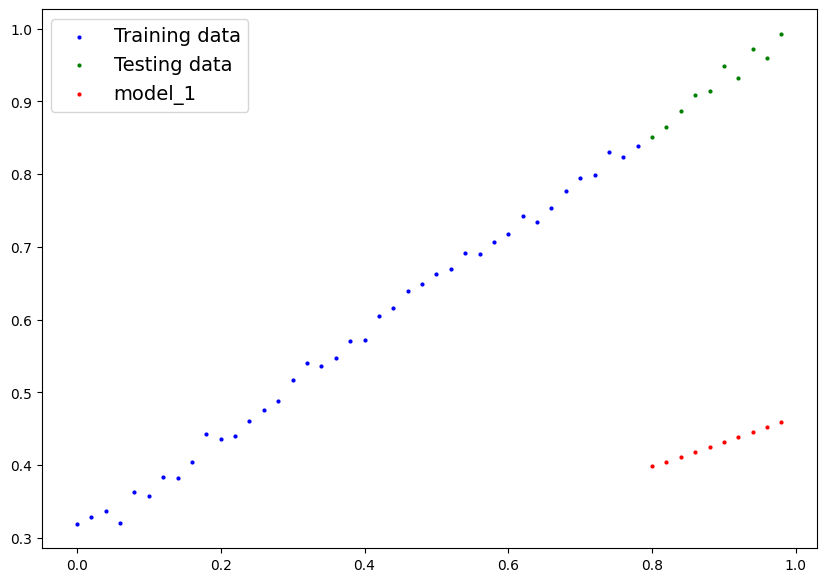

In [12]:
plot_predictions(model_1_predict=y_preds)

On average, what do you expect the error in each prediction to be?



In [13]:
#difference between the real values of the targets (labels of the test set) and the predicted labels by the model before any training is performed....obviously, performance is not optimal.
y_test - y_preds

tensor([[0.4535],
        [0.4599],
        [0.4757],
        [0.4904],
        [0.4899],
        [0.5166],
        [0.4936],
        [0.5265],
        [0.5079],
        [0.5343]])

## 3. Estimate model parameters with least square minimizer
Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly). You can see this from the errors, they're essentially hovering around 'chance', 50/50!

To fix that, we can estimate the model's parameters, the `weights` ($\beta_1$) and `bias` ($\beta_0$) values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

The least squares approach chooses $\beta_1$  and $\beta_0$ to minimize the residual sum of squares(RSS). The minimizing values can be shown to be

$$
\hat{\beta_1}=\frac{\sum^{n}_{i=1}(x_i-\bar{x})(y_i-\bar{y})}{\sum^{n}_{i=1}(x_i-\bar{x})^2},
\hat{\beta_0}=\bar{y}-\hat{\beta_1}\bar{x}
$$

$$
where \space
\bar{y}=\frac{1}{n}\sum^n_{i=1}y_i,
\bar{x}=\frac{1}{n}\sum^n_{i=1}x_i, \space are \space the \space sample \space means.
$$

In [14]:
# Create a Linear Regression model with least square minimizer
class LinearRegressionModel_0:
    def __init__(self):
        self.beta_0 = None
        self.beta_1 = None

    # Estimate model parameters with least square minimizer
    def estimate(self, X, y):
        # Calculate the mean of x and y
        x_mean = torch.mean(X)
        y_mean = torch.mean(y)

        # Calculate β1 by equation
        numerator = torch.sum((X - x_mean) * (y - y_mean))
        denominator = torch.sum((X - x_mean) ** 2)
        self.beta_1 = numerator / denominator

        # Calculate β0 by equation
        self.beta_0 = y_mean - self.beta_1 * x_mean

    def predict(self, X):
        # Predict
        return self.beta_0 + self.beta_1 * X

    def parameters(self):
        # Return model parameters
        return [self.beta_1, self.beta_0]

# Create an instance of the model
model_0 = LinearRegressionModel_0()

# Estimate model parameters with least square minimizer
model_0.estimate(X_train, y_train)

# Check the Parameter
list(model_0.parameters())

[tensor(0.6999), tensor(0.3011)]

### Let's visualise these predictions!

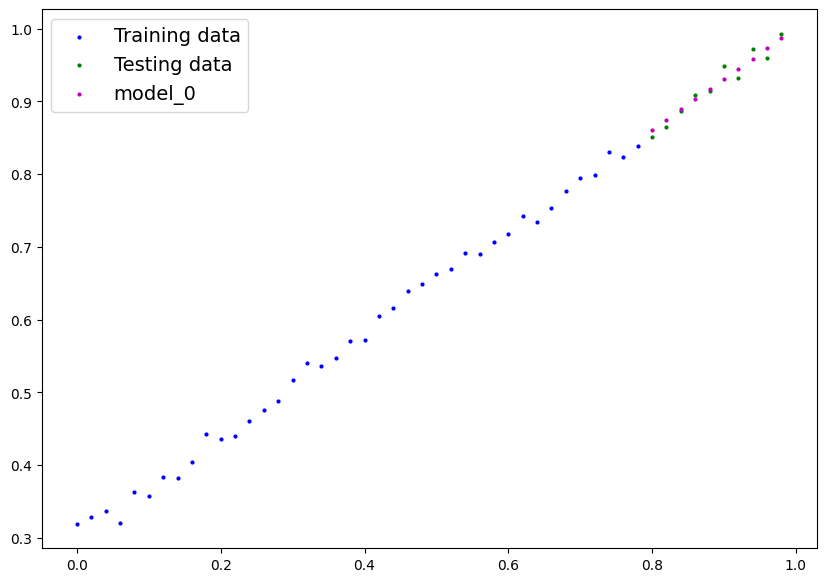

In [15]:
# Predicting the test set using model1
y_preds_model_0 = model_0.predict(X_test)

# Visualisation results
plot_predictions(model_0_predict=y_preds_model_0)

### victory!

## 4. [Optional below] Training `LinearRegressionModel()` with gradient descent

Alternative to the above closed form parameter estimation, we can also estimate the model's parameters with gradient descent, the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

We could hard code this (since we know the default values `weight=0.7` and `bias=0.3`), after all, these are the ground truth values and they would work! But that defeats the whole purpose of building the model!
So, we need to train the model, shift its parameters gradually until the output of the model during the training process (y_train) gets closer to y (ground truth). At which point, we expect that the estimated `weight` and `bias` to be close to the ground truth values of `weight=0.7` and `bias=0.3`.

### Creating a loss function and optimizer in PyTorch

For the model we built to update its parameters (that is the weights and bias in this case) on its own, we'll need to add a few more things: And that's a [**loss function**](https://pytorch.org/docs/stable/nn.html#loss-functions) as well as an [**optimizer**](https://pytorch.org/docs/stable/optim.html).

The rolls of these are:

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (`y_train` and `y_test`). Lower is better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

We will now create a loss and optimizer functions that are suitable for the model we built ( that is: a linear regression model). Bear in mind that the choice of which loss function and which optimizer to use will depend on the nature of the problem you are working on.

However, there are some common choices that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizers. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, we will use MAE (which is under [`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)) in PyTorch as our loss function.

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)

*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

And we will use SGD, [`torch.optim.SGD(params, lr)`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) where:

* `params` is the target model parameters you'd like to optimize (in this case the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you would like the optimizer to update the parameters with.

Recall that:

$$ \boldsymbol{\theta}' = \boldsymbol{\theta} - \alpha \nabla C$$

Where $\alpha$ is learning rate, $\theta$ are the weights of the model before the update and $\theta$**'** is the weight vector following the update. Higher $\alpha$  means the optimizer will attempt larger updates (these can sometimes be too large and the optimizer will fail to converge on an optimal solution), smaller means the optimizer will attempt smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values or may get stuck in a local minima).

The learning rate is considered a **hyperparameter** (since it's set by the coder). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)) and is a topic you will be introduced to later on.



In [16]:
# Create the loss function
loss_fn = nn.L1Loss() # as discussed above MAE loss is L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # parameters (weight + bias) of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=larger updates (less stable and may miss a global (or local) minimum), lower=smaller updates (might take a long time, or converge on a less optimal solution))

### Creating an optimization (ie training) loop in PyTorch

One of the reasons PyTorch is quite a powerful framework to build AI models with is because it gives the developer total control of over all aspects of the training and testing processes. In PyTorch, the developer has to design a training/testing loop from the ground up.

We are now going to bring the model_1 object, the loss and optimizer functions together we created to weave the training loop for this model.

The training loop involves the model going through the training data and learning the relationships between the `features` (that is X) and `labels`, measuring how wrong our predictions are (training loss), propogating backword, and stepping the optimizer (it will make sense shortly!).

On the other hand, the testing loop involves freezing the model using the `torch.inference_mode()` context manager, going through the testing data and evaluating how wrong we are (test loss) on the test data. Freezing here means that the model weights are **not** updated when we give it testing data. We are purely interested in its performance at that iteration of training/testing. For example, if we're at the 150th epoch, once the model weights have been updated, we freeze the parameters using `model.eval()` and `torch.inference_mode()`, then pass it some testing data to measure performance without actually any learning taking place.

They are described as "loops" because we want our model to look (loop through) at each sample in each dataset (usually, several times).

The PyTorch training loop can be viewed as follows (which is broadly agnostic of the type of architecture you are training):
> 1. Set the model to training mode and run a forward pass.
2. Calculate the loss.
3. Zero the gradients using `torch.optim.Optimizer.zero_grad()`. This is important otherwise the starting point would be the gradients calculated in the previous iteration rather than zero.
4. Backpropagate through the model and calculate the gradients with respect to each parameter where `requires_grad` was set to `True`. An excellent explanation can be found [here](https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944). Briefly, parameters in pytorch often have the option of having `requires_grad` set to either True or False. If True, the parameter in question will be learnable (changable with training). Otherwise, it will always be 'frozen' and not change with training.
5. Perfrom a model wide parameter update from 4.


| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` |
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

> **Note:** The above is just one simplified example of how the steps could be ordered or described. With experience you'll find making PyTorch training loops can be quite flexible.
> And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:
> * Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
> * Zero gradients (`optimizer.zero_grad()`) *before* stepping them (`optimizer.step()`).
> * Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).


This is an excellent visual explanation of what Backpropagation is and how it works from the famous 3Blue1Brown Youtune channel [What is backpropagation really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U)


### PyTorch testing loop

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` |
| 3 | Calulate evaluation metrics (optional) | Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. Recall that the model is already in **evaluation** mode and all parameters are frozen. When testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

Remember that the purpose of the test loop is to keep track of the progression of the learning process. Essentially, we would like to, quantitatively, be able to tell how close, and how fast, the model's trainable parameters are moving towards a value that minimises the loss.

Let's put all of the above together and train our model for 100 **epochs** (forward passes through the data) and we'll evaluate it every 10 epochs.


In [17]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the entirety of the training data, as it stands, X is really tiny but in practice you may be dealing with datasets containing millions of images)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_1.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_1(X_train)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_1.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_1(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.314001202583313 | MAE Test Loss: 0.4813689589500427 
Epoch: 10 | MAE Train Loss: 0.19879117608070374 | MAE Test Loss: 0.34665900468826294 
Epoch: 20 | MAE Train Loss: 0.08885543048381805 | MAE Test Loss: 0.21723385155200958 
Epoch: 30 | MAE Train Loss: 0.056596409529447556 | MAE Test Loss: 0.14815595746040344 
Epoch: 40 | MAE Train Loss: 0.0474015548825264 | MAE Test Loss: 0.11277981102466583 
Epoch: 50 | MAE Train Loss: 0.043605510145425797 | MAE Test Loss: 0.09911008924245834 
Epoch: 60 | MAE Train Loss: 0.040115512907505035 | MAE Test Loss: 0.08809003978967667 
Epoch: 70 | MAE Train Loss: 0.036625515669584274 | MAE Test Loss: 0.0770699679851532 
Epoch: 80 | MAE Train Loss: 0.033135510981082916 | MAE Test Loss: 0.06604989618062973 
Epoch: 90 | MAE Train Loss: 0.029645521193742752 | MAE Test Loss: 0.055029820650815964 


#### Observe the trend in the training loss, why do you think it's going down?
#### Compare the decreasing trends in training and testing losses, what do you notice? What is reason behind the disparity?

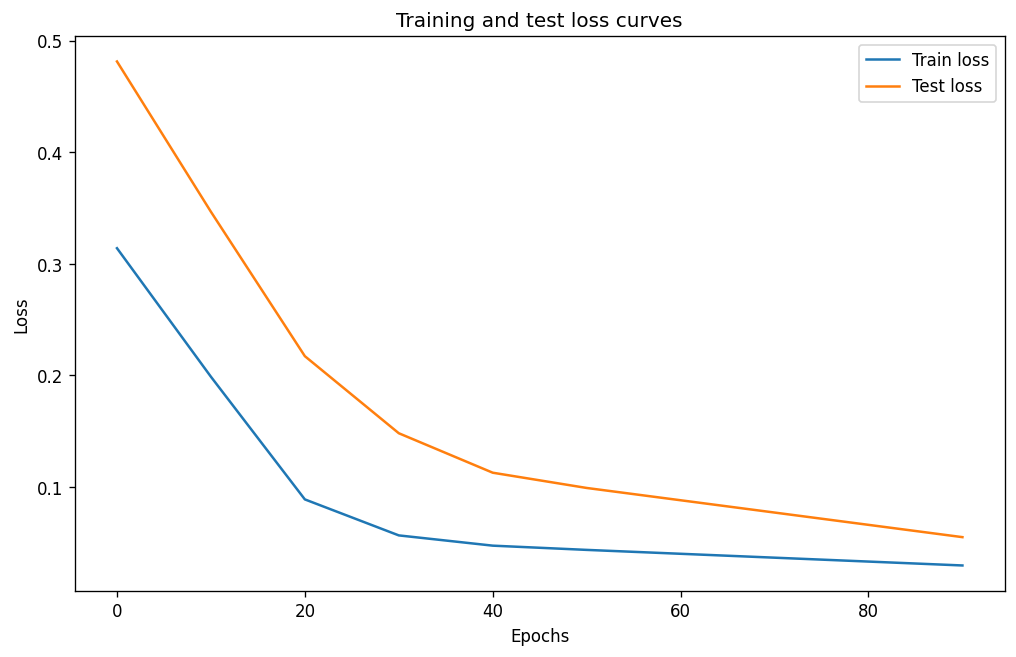

In [18]:
# Plot the loss curves
plt.figure(figsize=(10, 6), dpi=120)
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

#### You can now see the trends visually on the graph. Revisit the questions above and recall that `loss` is a measure of how wrong the model is.
Now, why do you think the loss is going down with each epoch? What happens if we increased the epochs from 100 to 1000? What would happen if keep it at 100 but decrease the learning by 10 folds?

We are not going to inspect our [`.state_dict()`](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)

In [19]:
# Find our model's learned parameters
print("###"*20)
print("The model learned the following values for weights and bias:")
print(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")
print("###"*20)


############################################################
The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5817])), ('bias', tensor([0.3598]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3
############################################################


You clearly see that the model's prameters have moved significantly closer from their random initialisation to the correct values of weights and bias!
> Can you make the distance between the learned parameters and the real ones (the ground truth) even smaller? Experiment with increasing the epochs to 200 and see what happens.


> **Exercise:** Try changing the `torch.manual_seed()` value two cells above, see what happens to the weights and bias values. Try restarting the runtime (or acessing the notebook from a different computer), when using the same seed (42), do you get the same results?!


## 5. Making predictions with the two above models (inference)

Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. You have to set the model to evaluation mode (`model.eval()`) before the forward pass.
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only). More on this below...


You will note that all of the above was done in the training/testing loop presented earlier. Moreover, the first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [20]:
# 1. Set the model in evaluation mode
model_1.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_1.to(device)
  # X_test = X_test.to(device)
  y_preds = model_1(X_test)

y_preds

tensor([[0.8251],
        [0.8368],
        [0.8484],
        [0.8600],
        [0.8717],
        [0.8833],
        [0.8949],
        [0.9066],
        [0.9182],
        [0.9298]])

Let's visualise these predictions!

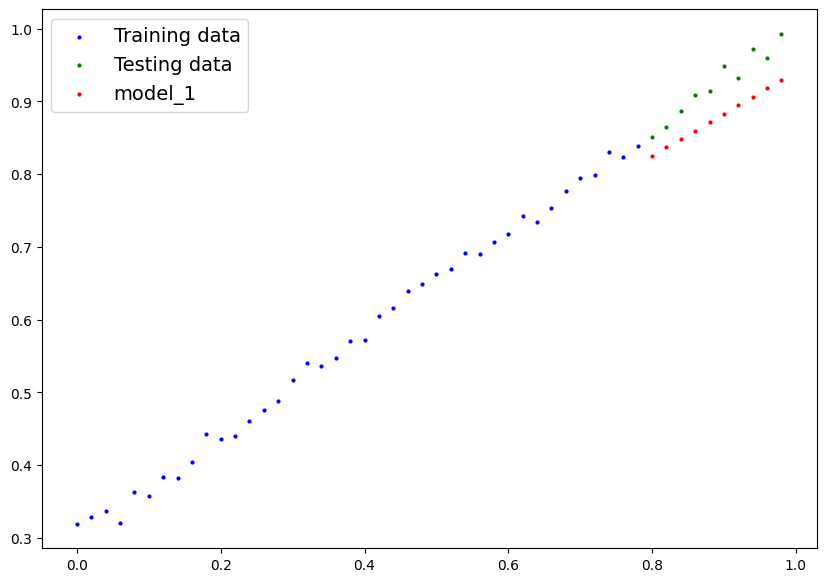

In [21]:
plot_predictions(model_1_predict=y_preds)

#### Finall,we can compare the predictions of the two models in the test set.

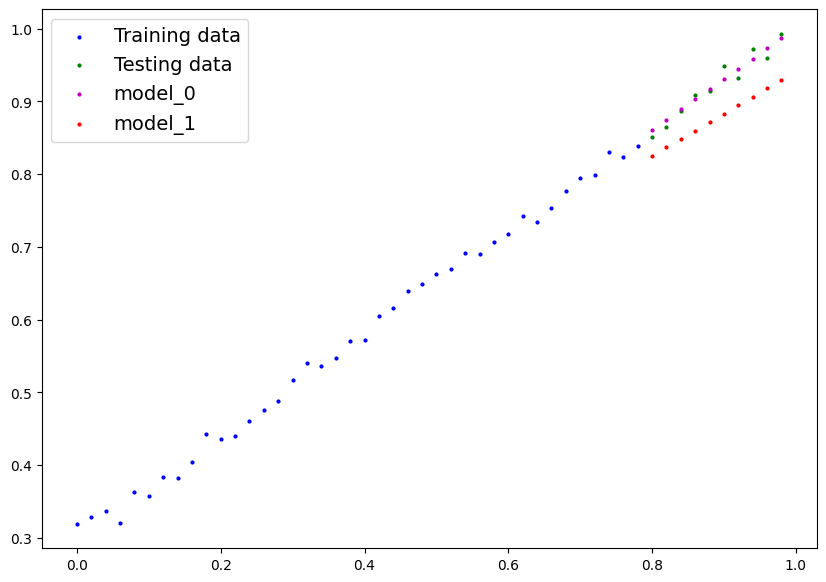

In [22]:
plot_predictions(model_0_predict=y_preds_model_0, model_1_predict=y_preds)

### And victory again!